In [1]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sub_df = pd.read_csv('sample_submission.csv')

In [3]:
data_df

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental
0,2018-01-01,NaN,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950
1,2018-01-02,NaN,-1.8,1.8,-4.3,36.0,22.0,42.0,7.9,82.3,1.8,4.9,7136
2,2018-01-03,NaN,-4.7,-0.4,-7.1,31.0,19.0,42.3,8.6,88.7,2.2,3.5,7156
3,2018-01-04,NaN,-4.7,-0.7,-8.7,39.0,24.0,43.0,6.2,63.9,1.4,3.5,7102
4,2018-01-05,NaN,-3.0,1.6,-5.6,51.0,35.0,48.4,8.2,84.5,1.7,3.6,7705
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,2020-12-27,0.0,5.8,10.0,1.4,70.0,42.0,62.9,5.9,61.5,1.8,2.8,37103
1091,2020-12-28,1.3,6.7,11.4,4.2,66.0,44.0,72.1,8.0,83.3,1.4,3.1,46912
1092,2020-12-29,0.2,0.1,4.3,-6.2,69.0,46.0,70.8,0.0,0.0,2.9,6.1,35747
1093,2020-12-30,NaN,-10.9,-6.2,-12.9,39.0,15.0,55.5,8.3,86.5,4.1,6.2,22488


Text(0.5, 0, 'sunshine_sum')

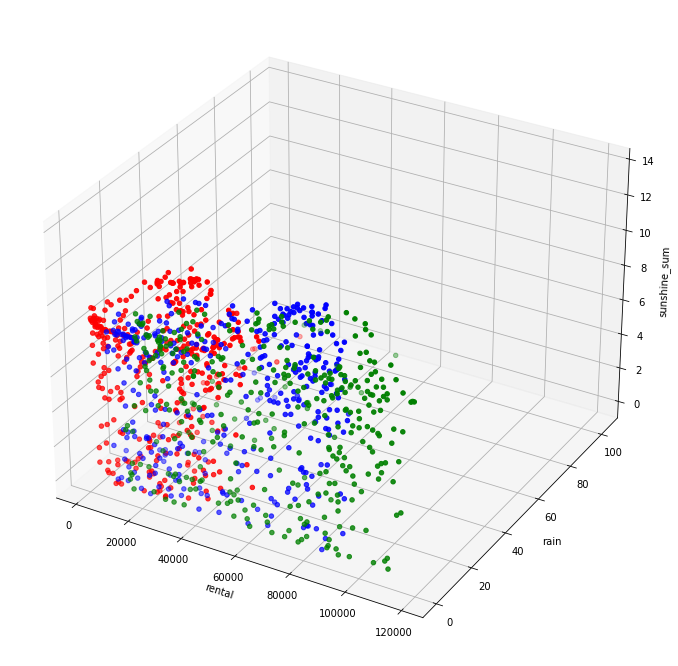

In [47]:
# # 3차원으로 rental, percipitation, sunshine_sum

# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure(figsize = (20,12))
# ax = fig.gca(projection = '3d')
# data_2018 = data_df[:364]
# data_2019 = data_df[365:729]
# data_2020 =data_df[730:]

# ax.scatter(data_2018['rental'],data_2018['precipitation'],data_2018['sunshine_sum'], c = "red",marker = 'o')
# ax.scatter(data_2019['rental'],data_2019['precipitation'],data_2019['sunshine_sum'], c = "Blue",marker = 'o')
# ax.scatter(data_2020['rental'],data_2020['precipitation'],data_2020['sunshine_sum'], c = "Green",marker = 'o')
# ax.set_xlabel("rental")
# ax.set_ylabel("rain")
# ax.set_zlabel("sunshine_sum")

In [4]:
# 강수량 결측치는 0으로 채운다. 
def fill_nan(data):
    data['precipitation'] = data['precipitation'].fillna(0)
    data = data.fillna(method='bfill')
    return data

In [5]:
data_df = fill_nan(data_df)

In [6]:
# date time 나누기
def seperate_datetime(dataframe):
    week_list = []
    year = []
    month = []
    for date in dataframe.date:
        year_point, month_point, day_point = date.split('-')
        year.append(int(year_point))
        month.append(int(month_point))
    dataframe['year'] = year
    dataframe['month'] = month
    for day in dataframe['date']:
        num = pd.date_range(day, day, freq='D').to_series()
        week_list.append(int(num.dt.dayofweek[0]))
    dataframe['day'] = week_list
    dataframe = dataframe.drop(['date'], axis=1)
    return dataframe

In [7]:
data_df = seperate_datetime(data_df)
data_df

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,year,month,day
0,0.0,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950,2018,1,0
1,0.0,-1.8,1.8,-4.3,36.0,22.0,42.0,7.9,82.3,1.8,4.9,7136,2018,1,1
2,0.0,-4.7,-0.4,-7.1,31.0,19.0,42.3,8.6,88.7,2.2,3.5,7156,2018,1,2
3,0.0,-4.7,-0.7,-8.7,39.0,24.0,43.0,6.2,63.9,1.4,3.5,7102,2018,1,3
4,0.0,-3.0,1.6,-5.6,51.0,35.0,48.4,8.2,84.5,1.7,3.6,7705,2018,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,0.0,5.8,10.0,1.4,70.0,42.0,62.9,5.9,61.5,1.8,2.8,37103,2020,12,6
1091,1.3,6.7,11.4,4.2,66.0,44.0,72.1,8.0,83.3,1.4,3.1,46912,2020,12,0
1092,0.2,0.1,4.3,-6.2,69.0,46.0,70.8,0.0,0.0,2.9,6.1,35747,2020,12,1
1093,0.0,-10.9,-6.2,-12.9,39.0,15.0,55.5,8.3,86.5,4.1,6.2,22488,2020,12,2


In [8]:
# 요일 데이터 부여
def weekday_onehotcode(dataframe):
    mon = dataframe[dataframe['day'] == 0]
    mon['day'] = 'mon'
    tue = dataframe[dataframe['day'] == 1]
    tue['day'] = 'tue'
    wed = dataframe[dataframe['day'] == 2]
    wed['day'] = 'wed'
    thu = dataframe[dataframe['day'] == 3]
    thu['day'] = 'thu'
    fri = dataframe[dataframe['day'] == 4]
    fri['day'] = 'fri'
    sat = dataframe[dataframe['day'] == 5]
    sat['day'] = 'sat'
    sun = dataframe[dataframe['day'] == 6]
    sun['day'] = 'sun'
    dataframe = pd.concat([mon, tue, wed, thu, fri, sat, sun], axis=0)
    dataframe = pd.get_dummies(dataframe)
    return dataframe

In [9]:
# # 요일 데이터 부여
# def weekday_onehotcode(dataframe):
#     sun = dataframe[dataframe['day'] == 6]
#     sun['day'] = 'sun'
#     dataframe = pd.concat([sun], axis=0)
#     dataframe = pd.get_dummies(dataframe)
#     return dataframe

In [10]:
data_df = weekday_onehotcode(data_df)
data_df

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,...,rental,year,month,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,0.0,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,...,4950,2018,1,0,1,0,0,0,0,0
7,0.9,1.3,4.0,-1.2,49.0,37.0,51.9,0.5,5.2,1.8,...,6309,2018,1,0,1,0,0,0,0,0
14,0.2,4.7,7.7,1.8,63.0,45.0,63.9,6.5,65.7,1.4,...,6993,2018,1,0,1,0,0,0,0,0
21,3.3,0.2,4.0,-5.3,38.0,21.0,56.5,0.7,7.0,1.5,...,4929,2018,1,0,1,0,0,0,0,0
28,0.0,-8.5,-4.7,-11.6,39.0,16.0,35.0,8.9,87.3,2.7,...,4425,2018,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,0.0,-0.6,2.6,-3.6,26.0,16.0,59.6,1.5,15.3,2.2,...,32211,2020,11,0,0,0,1,0,0,0
1069,0.0,4.5,9.1,1.2,45.0,33.0,66.9,6.0,61.9,1.8,...,40616,2020,12,0,0,0,1,0,0,0
1076,2.9,-1.1,2.0,-6.0,36.0,25.0,74.9,1.1,11.5,2.9,...,14362,2020,12,0,0,0,1,0,0,0
1083,0.0,-3.7,1.1,-8.2,27.0,16.0,50.4,9.1,94.8,2.0,...,23442,2020,12,0,0,0,1,0,0,0


In [11]:
def year_onehotcode(dataframe):
    a = dataframe[dataframe['year'] == 2018]
    a['year'] = 'a'
    b = dataframe[dataframe['year'] == 2019]
    b['year'] = 'b'
    c = dataframe[dataframe['year'] == 2020]
    c['year'] = 'c'
    dataframe = pd.concat([a, b, c], axis=0)
    dataframe = pd.get_dummies(dataframe)
    return dataframe

In [12]:
data_df = year_onehotcode(data_df)

In [13]:
data_df

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,...,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed,year_a,year_b,year_c
0,0.0,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,...,0,1,0,0,0,0,0,1,0,0
7,0.9,1.3,4.0,-1.2,49.0,37.0,51.9,0.5,5.2,1.8,...,0,1,0,0,0,0,0,1,0,0
14,0.2,4.7,7.7,1.8,63.0,45.0,63.9,6.5,65.7,1.4,...,0,1,0,0,0,0,0,1,0,0
21,3.3,0.2,4.0,-5.3,38.0,21.0,56.5,0.7,7.0,1.5,...,0,1,0,0,0,0,0,1,0,0
28,0.0,-8.5,-4.7,-11.6,39.0,16.0,35.0,8.9,87.3,2.7,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,0.0,-0.6,2.6,-3.6,26.0,16.0,59.6,1.5,15.3,2.2,...,0,0,0,1,0,0,0,0,0,1
1069,0.0,4.5,9.1,1.2,45.0,33.0,66.9,6.0,61.9,1.8,...,0,0,0,1,0,0,0,0,0,1
1076,2.9,-1.1,2.0,-6.0,36.0,25.0,74.9,1.1,11.5,2.9,...,0,0,0,1,0,0,0,0,0,1
1083,0.0,-3.7,1.1,-8.2,27.0,16.0,50.4,9.1,94.8,2.0,...,0,0,0,1,0,0,0,0,0,1


In [14]:
def rental_rate(dataframe):
    y1 = dataframe[dataframe['year'] == 2018]['rental'] * 2.3
    y2 = dataframe[dataframe['year'] == 2019]['rental'] * 1.2
    y3 = dataframe[dataframe['year'] == 2020]['rental']
    new = pd.concat([y1, y2, y3], axis=0).to_frame()
    dataframe['rental'] = new['rental']
    return True

In [15]:
data_df.sort_index()

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,...,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed,year_a,year_b,year_c
0,0.0,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,...,0,1,0,0,0,0,0,1,0,0
1,0.0,-1.8,1.8,-4.3,36.0,22.0,42.0,7.9,82.3,1.8,...,0,0,0,0,0,1,0,1,0,0
2,0.0,-4.7,-0.4,-7.1,31.0,19.0,42.3,8.6,88.7,2.2,...,0,0,0,0,0,0,1,1,0,0
3,0.0,-4.7,-0.7,-8.7,39.0,24.0,43.0,6.2,63.9,1.4,...,0,0,0,0,1,0,0,1,0,0
4,0.0,-3.0,1.6,-5.6,51.0,35.0,48.4,8.2,84.5,1.7,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,0.0,5.8,10.0,1.4,70.0,42.0,62.9,5.9,61.5,1.8,...,0,0,0,1,0,0,0,0,0,1
1091,1.3,6.7,11.4,4.2,66.0,44.0,72.1,8.0,83.3,1.4,...,0,1,0,0,0,0,0,0,0,1
1092,0.2,0.1,4.3,-6.2,69.0,46.0,70.8,0.0,0.0,2.9,...,0,0,0,0,0,1,0,0,0,1
1093,0.0,-10.9,-6.2,-12.9,39.0,15.0,55.5,8.3,86.5,4.1,...,0,0,0,0,0,0,1,0,0,1


In [16]:
def dirt_class(dataframe):
    for i in range(len(dataframe)):
        if 0<dataframe['PM10'][i]<=30:
            dataframe['dirt_class'][i] = 4
        elif 31<= dataframe['PM10'][i]<80:
            dataframe['dirt_class'][i] = 3
        elif 81<= dataframe['PM10'][i] < 150:
            dataframe['dirt_class'][i] = 2
        elif 151<= dataframe['PM10'][i]:
            dataframe['dirt_class'][i] = 0
    return dataframe

def bad_dirt_class(dataframe):
    for i in range(len(dataframe)):
        if 0<dataframe['PM2.5'][i] <= 99:
            dataframe['bad_dirt_class'][i] = 15
        elif 100<=dataframe['PM2.5'][i]<=199:
            dataframe['PM2.5'][i] = 10
        elif 200<=dataframe['PM2.5'][i]<=799:
            dataframe['PM2.5'][i] = 5
        elif 800<=dataframe['PM2.5'][i]:
            dataframe['PM2.5'][i] = 0
    return dataframe


                

# 함수 돌리기

In [17]:
bicycle = pd.read_csv('train.csv')
bicycle = seperate_datetime(bicycle)
bicycle = fill_nan(bicycle)
rental_rate(bicycle)
bicycle = weekday_onehotcode(bicycle)
# bicycle = year_onehotcode(bicycle)
# bicycle = month_onehotcode(bicycle)

bicycle['dirt_class'] = bicycle['PM10'].copy()
bicycle = dirt_class(bicycle)
bicycle = bicycle.drop('PM10', axis = 1)

bicycle['bad_dirt_class'] = bicycle['PM2.5'].copy()
bicycle = bad_dirt_class(bicycle)
bicycle = bicycle.drop('PM2.5', axis = 1)

bicycle.sort_index()
bicycle

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,...,month,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed,dirt_class,bad_dirt_class
0,0.0,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,...,1,0,1,0,0,0,0,0,3.0,15.0
7,0.9,1.3,4.0,-1.2,49.0,37.0,51.9,0.5,5.2,1.8,...,1,0,1,0,0,0,0,0,3.0,15.0
14,0.2,4.7,7.7,1.8,63.0,45.0,63.9,6.5,65.7,1.4,...,1,0,1,0,0,0,0,0,3.0,15.0
21,3.3,0.2,4.0,-5.3,38.0,21.0,56.5,0.7,7.0,1.5,...,1,0,1,0,0,0,0,0,3.0,15.0
28,0.0,-8.5,-4.7,-11.6,39.0,16.0,35.0,8.9,87.3,2.7,...,1,0,1,0,0,0,0,0,3.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,0.0,-0.6,2.6,-3.6,26.0,16.0,59.6,1.5,15.3,2.2,...,11,0,0,0,1,0,0,0,4.0,15.0
1069,0.0,4.5,9.1,1.2,45.0,33.0,66.9,6.0,61.9,1.8,...,12,0,0,0,1,0,0,0,3.0,15.0
1076,2.9,-1.1,2.0,-6.0,36.0,25.0,74.9,1.1,11.5,2.9,...,12,0,0,0,1,0,0,0,3.0,15.0
1083,0.0,-3.7,1.1,-8.2,27.0,16.0,50.4,9.1,94.8,2.0,...,12,0,0,0,1,0,0,0,4.0,15.0


# feature 추가하기 - train

In [18]:
T = bicycle['temp_mean']  # 섭씨
V = bicycle['wind_mean']  # 바람
R = bicycle['humidity']  # 습도
H = (bicycle['temp_mean'] * 1.8) + 32  # 화씨
feel_degree = 13.12 + 0.6215 * T - 11.37 * V**0.16 + 0.3965 * V**0.16
badfeel_degree = 9/5 * T - 0.55 * (1 - R/100) * (9/5 * T - 26) + 32
heat_degree = -42.379 + 2.05901523 * H + 10.14333127 * R - 0.22475541 * H * R - 6.83783 * 10**-3 * H**2 - 5.481717 * 10**-2 * R**2 + 1.22874 * 10**-3 * H**2 * R + 8.5282 * 10**-4 * H * R**2 - 1.99 * 10**-6 * H**2 * R**2
bicycle['cold_feel'] = bicycle['temp_lowest']*bicycle['wind_max']
bicycle['feel_degree'] = feel_degree
# bicycle['badfeel_degree'] = badfeel_degree
# bicycle['heat_degree'] = heat_degree

In [19]:
# sns.pairplot(bicycle, hue = 'year', markers = ['o','s','d'])
# plt.show()

In [20]:
bicycle_test = pd.read_csv('test.csv')
bicycle_test_date = bicycle_test['date']
bicycle_test = seperate_datetime(bicycle_test)
bicycle_test = fill_nan(bicycle_test)  # 바로 뒤에 값으로 결측치를 채우므로 seperate 밑이 와야함
bicycle_test = weekday_onehotcode(bicycle_test)
# bicycle_test = month_onehotcode(bicycle_test)

bicycle_test['dirt_class'] = bicycle_test['PM10'].copy()
bicycle_test = dirt_class(bicycle_test)
bicycle_test = bicycle_test.drop('PM10', axis = 1)

bicycle_test['bad_dirt_class'] = bicycle_test['PM2.5'].copy()
bicycle_test = bad_dirt_class(bicycle_test)
bicycle_test = bicycle_test.drop('PM2.5', axis = 1)

bicycle_test = bicycle_test.sort_index()
bicycle_test

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,...,month,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed,dirt_class,bad_dirt_class
0,0.0,-4.2,1.6,-9.8,30.0,17.0,64.0,6.5,67.7,2.0,...,1,1,0,0,0,0,0,0,4.0,15.0
1,0.0,-5.0,-1.4,-8.4,34.0,12.0,38.5,9.0,93.8,2.6,...,1,0,0,1,0,0,0,0,3.0,15.0
2,0.0,-5.6,-2.0,-9.1,39.0,14.0,45.0,5.5,56.7,2.0,...,1,0,0,0,1,0,0,0,3.0,15.0
3,0.0,-3.5,0.3,-8.4,40.0,23.0,51.4,4.6,47.4,1.7,...,1,0,1,0,0,0,0,0,3.0,15.0
4,0.0,-5.5,-2.1,-9.9,30.0,17.0,52.8,8.6,88.7,2.9,...,1,0,0,0,0,0,1,0,4.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.0,-7.6,-3.9,-12.9,33.0,20.0,60.9,3.8,39.6,1.7,...,12,0,1,0,0,0,0,0,3.0,15.0
361,0.0,-4.1,-0.9,-8.5,51.0,38.0,73.8,1.7,17.7,2.2,...,12,0,0,0,0,0,1,0,3.0,15.0
362,0.2,0.4,5.9,-3.8,66.0,49.0,72.9,1.8,18.8,2.6,...,12,0,0,0,0,0,0,1,3.0,15.0
363,0.0,-3.9,0.2,-6.8,30.0,17.0,48.5,7.3,76.0,3.3,...,12,0,0,0,0,1,0,0,4.0,15.0


# feature 추가하기

In [21]:
T = bicycle_test['temp_mean']  # 섭씨
V = bicycle_test['wind_mean']  # 바람
R = bicycle_test['humidity']  # 습도
H = (bicycle_test['temp_mean'] * 1.8) + 32  # 화씨
feel_degree = 13.12 + 0.6215 * T - 11.37 * V**0.16 + 0.3965 * V**0.16
badfeel_degree = 9/5 * T - 0.55 * (1 - R/100) * (9/5 * T - 26) + 32
heat_degree = -42.379 + 2.05901523 * H + 10.14333127 * R - 0.22475541 * H * R - 6.83783 * 10**-3 * H**2 - 5.481717 * 10**-2 * R**2 + 1.22874 * 10**-3 * H**2 * R + 8.5282 * 10**-4 * H * R**2 - 1.99 * 10**-6 * H**2 * R**2
bicycle_test['cold_feel'] = bicycle_test['temp_lowest']*bicycle_test['wind_max']
bicycle_test['feel_degree'] = feel_degree
# bicycle_test['badfeel_degree'] = badfeel_degree
# bicycle_test['heat_degree'] = heat_degree

In [22]:
bicycle_test

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,...,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed,dirt_class,bad_dirt_class,cold_feel,feel_degree
0,0.0,-4.2,1.6,-9.8,30.0,17.0,64.0,6.5,67.7,2.0,...,0,0,0,0,0,0,4.0,15.0,-40.18,-1.750850
1,0.0,-5.0,-1.4,-8.4,34.0,12.0,38.5,9.0,93.8,2.6,...,0,1,0,0,0,0,3.0,15.0,-45.36,-2.773683
2,0.0,-5.6,-2.0,-9.1,39.0,14.0,45.0,5.5,56.7,2.0,...,0,0,1,0,0,0,3.0,15.0,-40.95,-2.620950
3,0.0,-3.5,0.3,-8.4,40.0,23.0,51.4,4.6,47.4,1.7,...,1,0,0,0,0,0,3.0,15.0,-26.88,-1.001098
4,0.0,-5.5,-2.1,-9.9,30.0,17.0,52.8,8.6,88.7,2.9,...,0,0,0,0,1,0,4.0,15.0,-56.43,-3.309794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.0,-7.6,-3.9,-12.9,33.0,20.0,60.9,3.8,39.6,1.7,...,1,0,0,0,0,0,3.0,15.0,-39.99,-3.549248
361,0.0,-4.1,-0.9,-8.5,51.0,38.0,73.8,1.7,17.7,2.2,...,0,0,0,0,1,0,3.0,15.0,-26.35,-1.877102
362,0.2,0.4,5.9,-3.8,66.0,49.0,72.9,1.8,18.8,2.6,...,0,0,0,0,0,1,3.0,15.0,-22.42,0.582417
363,0.0,-3.9,0.2,-6.8,30.0,17.0,48.5,7.3,76.0,3.3,...,0,0,0,1,0,0,4.0,15.0,-44.88,-2.587193


In [23]:
bicycle = bicycle.drop('sunshine_sum', axis =1)
# bicycle = bicycle.drop('sunshine_rate', axis =1)
# bicycle = bicycle.drop('rental', axis=1)
bicycle_test = bicycle_test.drop('sunshine_sum', axis =1)
# bicycle_test = bicycle_test.drop('sunshine_rate', axis =1)

In [24]:
# 

In [25]:
x = bicycle
x2 = bicycle_test
y = bicycle['rental']
# bicycle = bicycle.drop(['rental'], axis=1)

In [26]:
x = x.drop('rental', axis =1)

In [27]:
X_train = x
y_train = y
X_test = x2
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1, max_depth = 5, n_estimators = 500)
xg_reg.fit(X_train, y_train)
pred = xg_reg.predict(X_test) * 1.2
pred = pd.DataFrame(pred, columns=['rental'])
print(pred)
pred = np.ceil(pred)
result = pd.concat([bicycle_test_date, pred],axis=1)
result.to_csv('dirt_class_with_original.csv',index=False)
print(result)

           rental
0    29451.953125
1    29015.488281
2    24193.308594
3    30823.332031
4    29883.681641
..            ...
360  30896.570312
361  38567.839844
362  46325.753906
363  38199.757812
364  33988.457031

[365 rows x 1 columns]
           date   rental
0    2021-01-01  29452.0
1    2021-01-02  29016.0
2    2021-01-03  24194.0
3    2021-01-04  30824.0
4    2021-01-05  29884.0
..          ...      ...
360  2021-12-27  30897.0
361  2021-12-28  38568.0
362  2021-12-29  46326.0
363  2021-12-30  38200.0
364  2021-12-31  33989.0

[365 rows x 2 columns]
